In [2]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import Augmentor

In [5]:
data_augmentation_enabled = True
CLASSES = 31

In [6]:
def augment_images(input_dir, output_dir, num_augmentations=int(1e3)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for cls in range(1, CLASSES+1):
        in_dir = input_dir + '/' + str(cls)
        print('Augmenting images in ' + in_dir)
        out_dir = output_dir + '/' + str(cls)
        print('Augmenting into ' + out_dir)
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        p = Augmentor.Pipeline(source_directory=in_dir, output_directory="out")
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.zoom_random(probability=0.5, percentage_area=0.8)
        p.flip_left_right(probability=0.3)
        p.random_distortion(probability=0.5, grid_width=4, grid_height=4, magnitude=1)
        p.skew_tilt(probability=0.5, magnitude=0.1)
        p.random_erasing(probability=0.2, rectangle_area=0.1)
        p.sample(num_augmentations)
        #out is relative for augmentator :/ move
        os.rename(os.path.join(input_dir,str(cls),'out'), os.path.join(output_dir,str(cls)))

# note that function will fail if augmentations were already present
if data_augmentation_enabled:
    augment_images('train', 'train/da')

Augmenting images in train/1
Augmenting into train/da/1
Initialised with 6 image(s) found.
Output directory set to train/1/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBBAC79FEB0>: 100%|██████████| 1000/1000 [00:02<00:00, 469.33 Samples/s]               


Augmenting images in train/2
Augmenting into train/da/2
Initialised with 6 image(s) found.
Output directory set to train/2/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBBAC7C04C0>: 100%|██████████| 1000/1000 [00:02<00:00, 466.84 Samples/s]                


Augmenting images in train/3
Augmenting into train/da/3
Initialised with 6 image(s) found.
Output directory set to train/3/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBBAC79FA90>: 100%|██████████| 1000/1000 [00:02<00:00, 477.61 Samples/s]                


Augmenting images in train/4
Augmenting into train/da/4
Initialised with 6 image(s) found.
Output directory set to train/4/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBBAC7B14B0>: 100%|██████████| 1000/1000 [00:02<00:00, 479.23 Samples/s]               


Augmenting images in train/5
Augmenting into train/da/5
Initialised with 6 image(s) found.
Output directory set to train/5/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBBAC79E7A0>: 100%|██████████| 1000/1000 [00:02<00:00, 482.68 Samples/s]                


Augmenting images in train/6
Augmenting into train/da/6
Initialised with 6 image(s) found.
Output directory set to train/6/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBBAC7C1B70>: 100%|██████████| 1000/1000 [00:02<00:00, 482.28 Samples/s]                


Augmenting images in train/7
Augmenting into train/da/7
Initialised with 6 image(s) found.
Output directory set to train/7/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBBAC764FD0>: 100%|██████████| 1000/1000 [00:02<00:00, 468.03 Samples/s]                


Augmenting images in train/8
Augmenting into train/da/8
Initialised with 6 image(s) found.
Output directory set to train/8/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBBAC7C3D00>: 100%|██████████| 1000/1000 [00:02<00:00, 485.41 Samples/s]                


Augmenting images in train/9
Augmenting into train/da/9
Initialised with 6 image(s) found.
Output directory set to train/9/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBBAC7644F0>: 100%|██████████| 1000/1000 [00:02<00:00, 481.28 Samples/s]                


Augmenting images in train/10
Augmenting into train/da/10
Initialised with 6 image(s) found.
Output directory set to train/10/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBBAC7B1EA0>: 100%|██████████| 1000/1000 [00:02<00:00, 477.54 Samples/s]               


Augmenting images in train/11
Augmenting into train/da/11
Initialised with 6 image(s) found.
Output directory set to train/11/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBBAC753070>: 100%|██████████| 1000/1000 [00:02<00:00, 479.79 Samples/s]                


Augmenting images in train/12
Augmenting into train/da/12
Initialised with 6 image(s) found.
Output directory set to train/12/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBBAC79E470>: 100%|██████████| 1000/1000 [00:02<00:00, 478.06 Samples/s]                


Augmenting images in train/13
Augmenting into train/da/13
Initialised with 6 image(s) found.
Output directory set to train/13/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBBAC737BB0>: 100%|██████████| 1000/1000 [00:02<00:00, 470.20 Samples/s]               


Augmenting images in train/14
Augmenting into train/da/14
Initialised with 6 image(s) found.
Output directory set to train/14/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBCA8131300>: 100%|██████████| 1000/1000 [00:02<00:00, 448.24 Samples/s]               


Augmenting images in train/15
Augmenting into train/da/15
Initialised with 6 image(s) found.
Output directory set to train/15/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBBAC7528C0>: 100%|██████████| 1000/1000 [00:02<00:00, 466.82 Samples/s]               


Augmenting images in train/16
Augmenting into train/da/16
Initialised with 6 image(s) found.
Output directory set to train/16/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBCA810A4A0>: 100%|██████████| 1000/1000 [00:02<00:00, 478.00 Samples/s]                


Augmenting images in train/17
Augmenting into train/da/17
Initialised with 6 image(s) found.
Output directory set to train/17/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBBAC736EC0>: 100%|██████████| 1000/1000 [00:02<00:00, 477.36 Samples/s]                


Augmenting images in train/18
Augmenting into train/da/18
Initialised with 6 image(s) found.
Output directory set to train/18/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBCA810A590>: 100%|██████████| 1000/1000 [00:02<00:00, 465.23 Samples/s]               


Augmenting images in train/19
Augmenting into train/da/19
Initialised with 6 image(s) found.
Output directory set to train/19/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBBAC734550>: 100%|██████████| 1000/1000 [00:02<00:00, 480.76 Samples/s]               


Augmenting images in train/20
Augmenting into train/da/20
Initialised with 6 image(s) found.
Output directory set to train/20/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBCA8109210>: 100%|██████████| 1000/1000 [00:02<00:00, 476.44 Samples/s]                


Augmenting images in train/21
Augmenting into train/da/21
Initialised with 6 image(s) found.
Output directory set to train/21/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBBAC7352D0>: 100%|██████████| 1000/1000 [00:02<00:00, 484.24 Samples/s]               


Augmenting images in train/22
Augmenting into train/da/22
Initialised with 6 image(s) found.
Output directory set to train/22/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBCA8109EA0>: 100%|██████████| 1000/1000 [00:02<00:00, 477.35 Samples/s]                


Augmenting images in train/23
Augmenting into train/da/23
Initialised with 6 image(s) found.
Output directory set to train/23/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBBAC7521D0>: 100%|██████████| 1000/1000 [00:02<00:00, 479.39 Samples/s]               


Augmenting images in train/24
Augmenting into train/da/24
Initialised with 6 image(s) found.
Output directory set to train/24/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBBAC7C1D20>: 100%|██████████| 1000/1000 [00:02<00:00, 467.92 Samples/s]               


Augmenting images in train/25
Augmenting into train/da/25
Initialised with 6 image(s) found.
Output directory set to train/25/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBBAC751A50>: 100%|██████████| 1000/1000 [00:02<00:00, 476.56 Samples/s]                


Augmenting images in train/26
Augmenting into train/da/26
Initialised with 6 image(s) found.
Output directory set to train/26/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBBAC7C3700>: 100%|██████████| 1000/1000 [00:02<00:00, 476.77 Samples/s]               


Augmenting images in train/27
Augmenting into train/da/27
Initialised with 6 image(s) found.
Output directory set to train/27/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBBAC6FEE00>: 100%|██████████| 1000/1000 [00:02<00:00, 479.45 Samples/s]               


Augmenting images in train/28
Augmenting into train/da/28
Initialised with 6 image(s) found.
Output directory set to train/28/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBCA819D360>: 100%|██████████| 1000/1000 [00:02<00:00, 481.04 Samples/s]               


Augmenting images in train/29
Augmenting into train/da/29
Initialised with 6 image(s) found.
Output directory set to train/29/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBBAC79C0D0>: 100%|██████████| 1000/1000 [00:02<00:00, 465.37 Samples/s]                


Augmenting images in train/30
Augmenting into train/da/30
Initialised with 6 image(s) found.
Output directory set to train/30/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBCA819DA50>: 100%|██████████| 1000/1000 [00:02<00:00, 476.78 Samples/s]                


Augmenting images in train/31
Augmenting into train/da/31
Initialised with 6 image(s) found.
Output directory set to train/31/out.

Processing <PIL.Image.Image image mode=RGB size=80x80 at 0x7FBBAC79D870>: 100%|██████████| 1000/1000 [00:02<00:00, 476.70 Samples/s]                


In [7]:
class CustomDataset(Dataset):
    def __init__(self, images, labels) -> None:
        self.images = images
        self.labels = labels

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]
        return image, label

    def __len__(self):
        return len(self.labels)

def png_load(dir_name):
    """
    Loads all *.png images
    """
    features = {}
    for f in glob(dir_name + '/*.png'):
        features[f] = np.array(Image.open(f), dtype=np.float64)
    return features


In [39]:
train_x = np.empty((0,80,80,3))
train_y = np.empty((0),dtype=int)

test_x = np.empty((0,80,80,3))
test_y = np.empty((0),dtype=int)

for i in range(1,CLASSES+1):
    train_i = np.array(list(png_load(os.path.join("train/da",str(i))).values()))
    label_i = np.full(len(train_i),i-1)
    train_x = np.concatenate((train_x, train_i), axis=0)
    train_y = np.concatenate((train_y,label_i), axis=0)

    test_i = np.array(list(png_load(os.path.join("dev",str(i))).values()))
    label_i = np.full(len(test_i),i-1)
    test_x = np.concatenate((test_x, test_i), axis=0)
    test_y = np.concatenate((test_y,label_i), axis=0)

print("Images were successfully loaded")

# convert 80,80,3 to 3,80,80
train_x = np.array(train_x)
train_x = np.transpose(train_x, (0, 3, 1, 2))

test_x = np.array(test_x)
test_x = np.transpose(test_x, (0, 3, 1, 2))

# Convert NumPy arrays to PyTorch tensors
train_tensors = torch.Tensor(train_x)
test_tensors = torch.Tensor(test_x)


# Create new TensorDataset instances with the modified labels
train_dataset = CustomDataset(train_tensors, train_y)
test_dataset = CustomDataset(test_tensors, test_y)
print("Dataset was successfully created")


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Images were successfully loaded
Dataset was successfully created


In [48]:
class SmallCNNMultiClass(nn.Module):
    def __init__(self, num_classes=CLASSES):
        super(SmallCNNMultiClass, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batch_norm1 = nn.BatchNorm2d(8)
        self.batch_norm2 = nn.BatchNorm2d(16)
        self.dropout = nn.Dropout2d(0.4)
        self.fc1 = nn.Linear(32 * 10 * 10, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        #VGG like
        x = self.pool(F.relu(self.conv1(x)))  # 40x40x8
        x = self.dropout(self.batch_norm1(x))
        x = self.pool(F.relu(self.conv2(x)))  # 20x20x16
        x = self.dropout(self.batch_norm2(x))
        x = self.pool(F.relu(self.conv3(x)))  # 10x10x32
        x = x.view(-1, 32 * 10 * 10)  # 3200
        x = self.fc1(x)  # 128
        x = self.fc2(x)
        return x

Epoch: 1/30, Loss: 586.8373, Accuracy: 0.3387, 21 and 62
Epoch: 2/30, Loss: 208.3732, Accuracy: 0.5000, 31 and 62
Epoch: 3/30, Loss: 141.6211, Accuracy: 0.5323, 33 and 62
Epoch: 4/30, Loss: 111.4580, Accuracy: 0.5000, 31 and 62
Epoch: 5/30, Loss: 92.9602, Accuracy: 0.5323, 33 and 62
Epoch: 6/30, Loss: 79.0204, Accuracy: 0.5806, 36 and 62
Epoch: 7/30, Loss: 74.1075, Accuracy: 0.5806, 36 and 62
Epoch: 8/30, Loss: 65.9542, Accuracy: 0.5645, 35 and 62
Epoch: 9/30, Loss: 61.9831, Accuracy: 0.5968, 37 and 62
Epoch: 10/30, Loss: 49.7935, Accuracy: 0.6129, 38 and 62
Epoch: 11/30, Loss: 53.9338, Accuracy: 0.5161, 32 and 62
Epoch: 12/30, Loss: 49.5825, Accuracy: 0.6129, 38 and 62
Epoch: 13/30, Loss: 44.5634, Accuracy: 0.5161, 32 and 62
Epoch: 14/30, Loss: 50.6033, Accuracy: 0.6129, 38 and 62
Epoch: 15/30, Loss: 39.7038, Accuracy: 0.5806, 36 and 62
Epoch: 16/30, Loss: 42.2963, Accuracy: 0.5806, 36 and 62
Epoch: 17/30, Loss: 41.4303, Accuracy: 0.5806, 36 and 62
Epoch: 18/30, Loss: 37.6160, Accurac

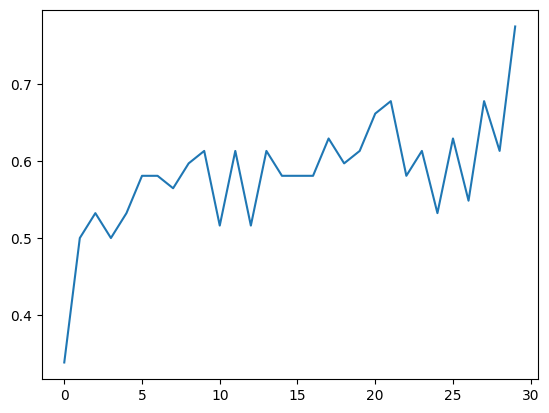

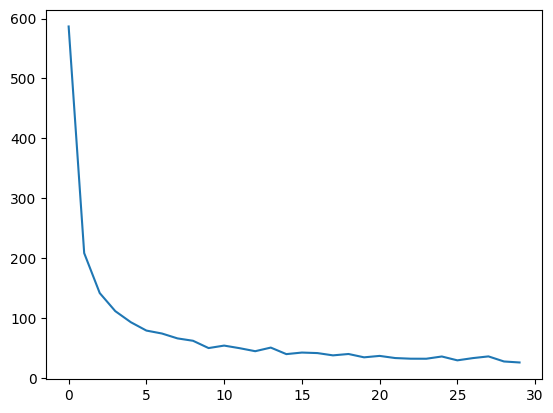

In [49]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu" 

model = SmallCNNMultiClass()
criterion = F.cross_entropy
model = model.to(dev)
# model = Net().to(dev)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Training loop
num_epochs = 30
losses = []
accuracys = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(dev), labels.to(dev)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # if not epoch % 10:
    # Evaluation on the dev set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dev_loader:
            inputs, labels = inputs.to(dev), labels.to(dev)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    losses.append(train_loss)
    accuracys.append(accuracy)
    print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, {correct} and {total}')
    if accuracy > 0.85:
        break

plt.figure()
plt.plot(accuracys)

plt.figure()
plt.plot(losses)

In [ ]:
if os.path.isfile('model-0.7742.pt')
    torch.save(model.state_dict(), 'model-0.7742.pt')

0.7741935483870968
28
tensor([[-26.4169,  -3.5410, -10.8196,  -0.5502, -32.6932,  -0.2680, -20.5778,
           3.2251, -25.4158, -28.0959,  -0.2982,  -2.6847, -28.3864, -12.8985,
          10.5251,  10.6980,  -0.6953,  20.6646,  12.2838,  20.1808,   0.6783,
          -4.9222, -10.2907,   1.3234,  16.0897, -20.9524,  17.1507,   8.7355,
          47.4353,   1.1802,  13.6893]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([28], device='cuda:0')


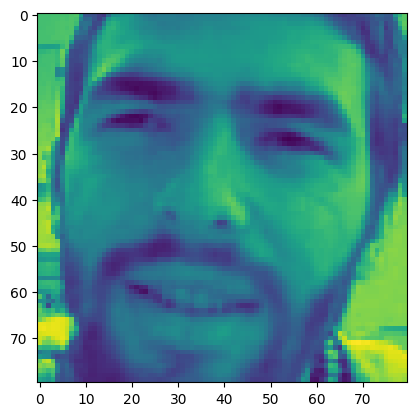

In [55]:
print(accuracy)
import random
x, y = random.choice(test_dataset)
print(y)

import matplotlib.pyplot as plt
plt.imshow(x[0,:,:])
x = torch.Tensor(x).to(dev)
model.eval()
output = model(x.unsqueeze(0))
print(output)
_, predicted = torch.max(output.data, 1)
print(predicted)